# Łukasz Kochańczyk, gr. 1

### 1. Pobierz i wczytaj dane

In [ ]:
!wget https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download/Bike-Sharing-Dataset.zip -O Bike-Sharing-Dataset.zip
!unzip Bike-Sharing-Dataset.zip
!cat Readme.txt

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("BikerRental").master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/29 14:31:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('day.csv', header=True, inferSchema=True)
df.show(5)
df.printSchema()

+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|instant|    dteday|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered| cnt|
+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|      1|2011-01-01|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654| 985|
|      2|2011-01-02|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670| 801|
|      3|2011-01-03|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1349|
|      4|2011-01-04|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|   108|      1454|1562|
|      5|2011-01-05|     1|  0|   1|      0|      3|   

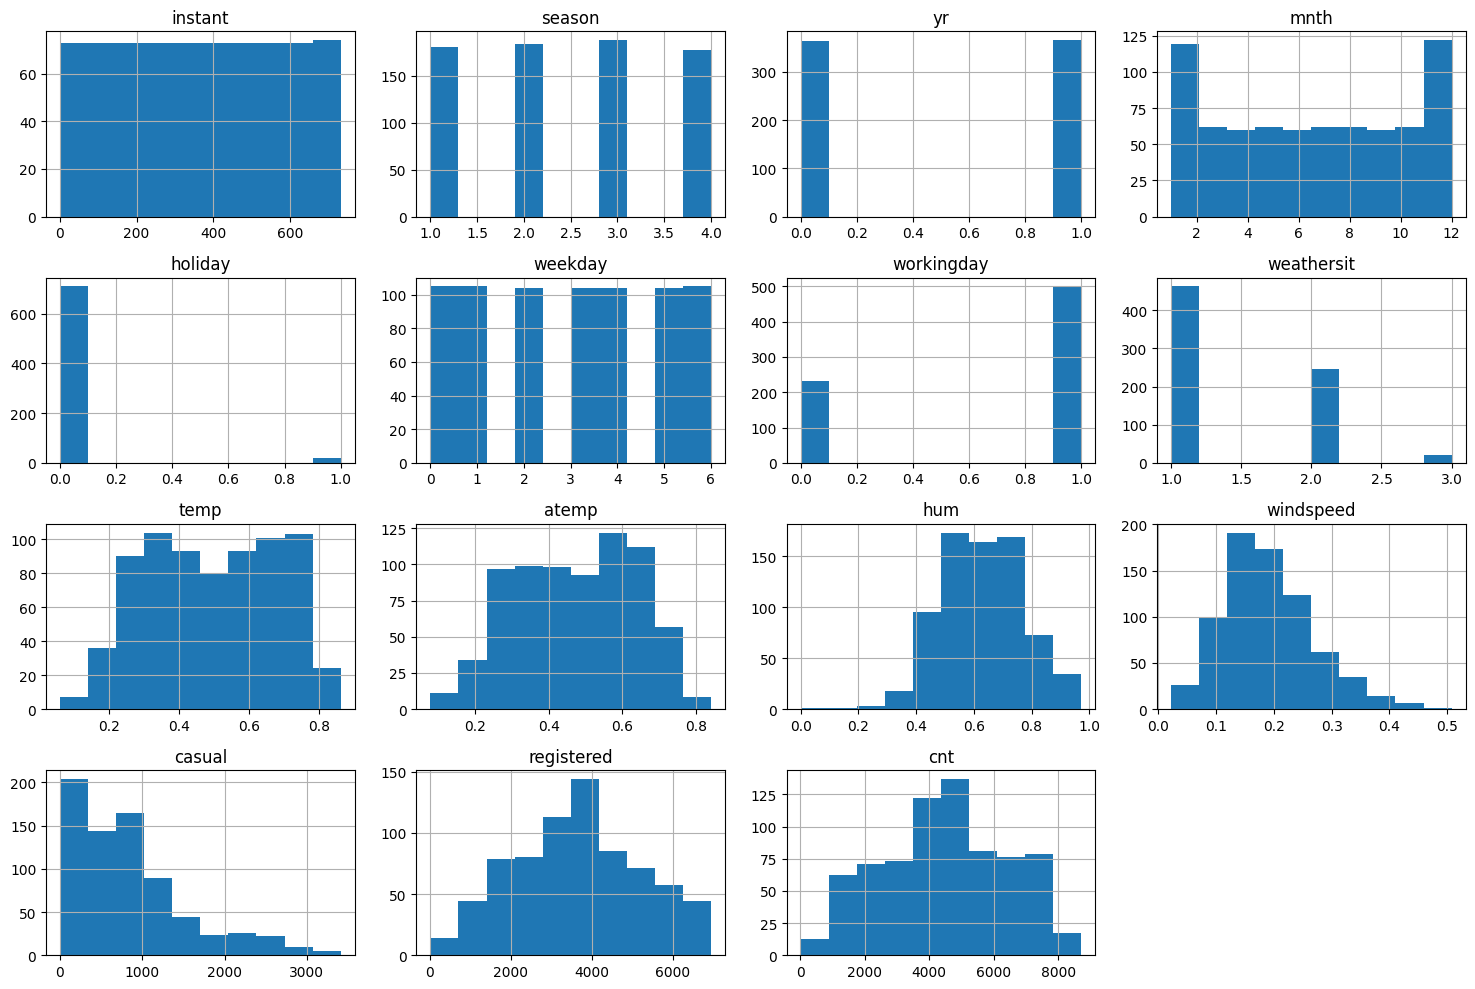

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,10)
pdf = df.toPandas()

pdf.hist()
plt.tight_layout()
plt.show()

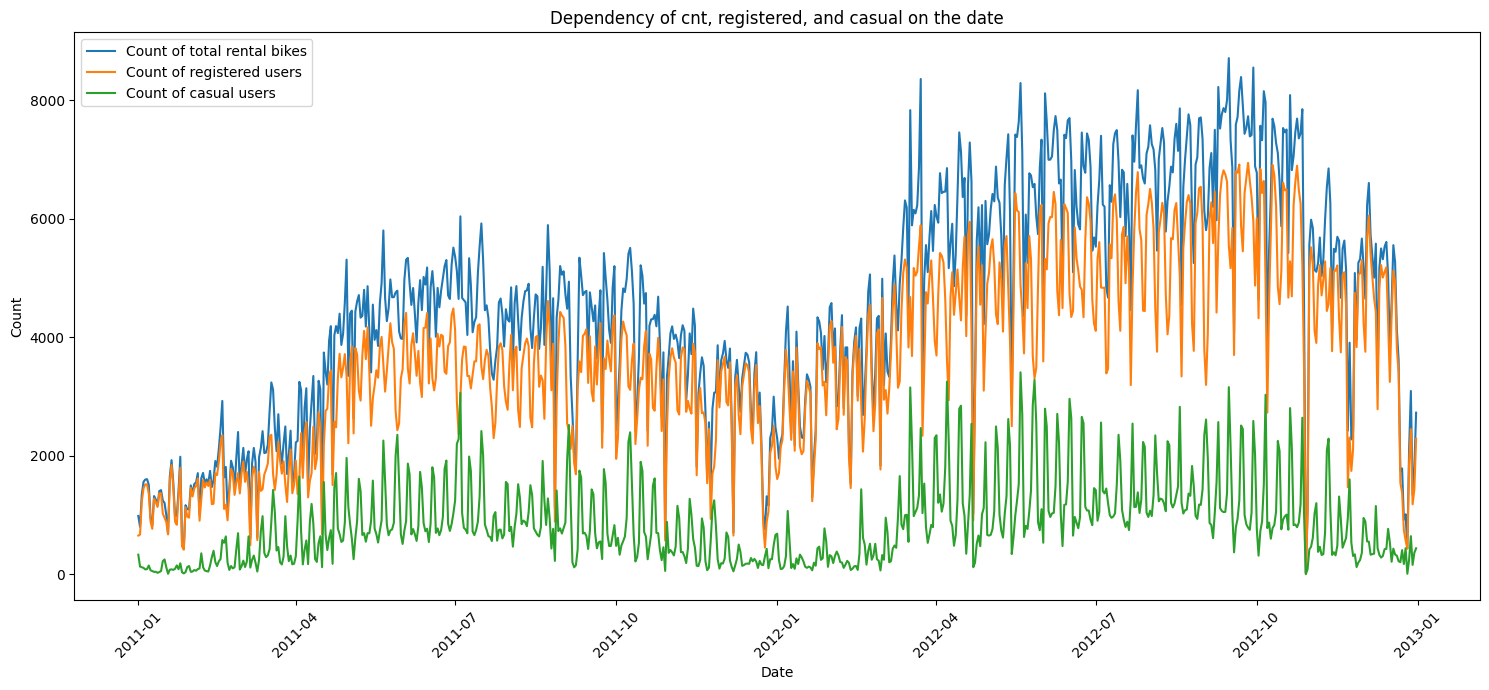

In [4]:
dates = df.select('dteday').rdd.flatMap(lambda x: x).collect()
data = df.select('cnt', 'registered', 'casual')
df_crc = data.toPandas()

plt.figure(figsize=(15, 7))
plt.plot(dates, df_crc['cnt'], label='Count of total rental bikes')
plt.plot(dates, df_crc['registered'], label='Count of registered users')
plt.plot(dates, df_crc['casual'], label='Count of casual users')

plt.title('Dependency of cnt, registered, and casual on the date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Dane BASIC - regresja (bez przetwarzania wstępnego)

In [5]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
def evaluate_metrics(df, metrics=['r2','rmse','mse','mae'], label_col='cnt', prediction_col='prediction'):
    results = {}
    for metric in metrics:
        evaluator = RegressionEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName=metric)
        results[metric] = evaluator.evaluate(df)
        
    return results

In [7]:
def train_and_test(df, lr=LinearRegression(maxIter=100, regParam=3.0, elasticNetParam=0.5, labelCol='cnt')):
    df_train, df_test = df.randomSplit([0.7, 0.3], seed=42)

    feature_cols = [c for c in df.columns if c != 'cnt']
    va = VectorAssembler(inputCols=feature_cols, outputCol='features')
    pipeline = Pipeline(stages=[va, lr])
    
    model = pipeline.fit(df_train)
    df_train_predictions = model.transform(df_train)
    df_test_predictions = model.transform(df_test)

    train_metrics = evaluate_metrics(df_train_predictions)
    test_metrics = evaluate_metrics(df_test_predictions)

    train_metric_str = ", ".join([f"{metric}: {val:.3f}" for metric, val in train_metrics.items()])
    test_metric_str = ", ".join([f"{metric}: {val:.3f}" for metric, val in test_metrics.items()])
    print(f"Train: {train_metric_str}")
    print(f"Test: {test_metric_str}")

    return model

In [8]:
from pyspark.sql.functions import unix_timestamp
import numpy as np

date_column_name = 'dteday'
df2 = df.withColumn('unixdate', unix_timestamp(date_column_name)).drop(date_column_name)

In [9]:
def calc_correlation_matrix(df):
    n = len(df.columns)
    rs = np.eye(n)
    
    for i in range(n):
        for j in range(i+1, n):
            r = df.stat.corr(df.columns[i], df.columns[j])
            rs[i][j], rs[j][i] = r, r

    return rs

In [10]:
import itertools
import matplotlib.pyplot as plt

def plot_matrix(cm, labels, normalize=False, title='', cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.matshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels)
    # ax.set_yticklabels(['']+labels)
    ax.set_yticklabels(labels)
    
    fmt = '.2f' #if normalize else 'd'
    thresh = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.show()

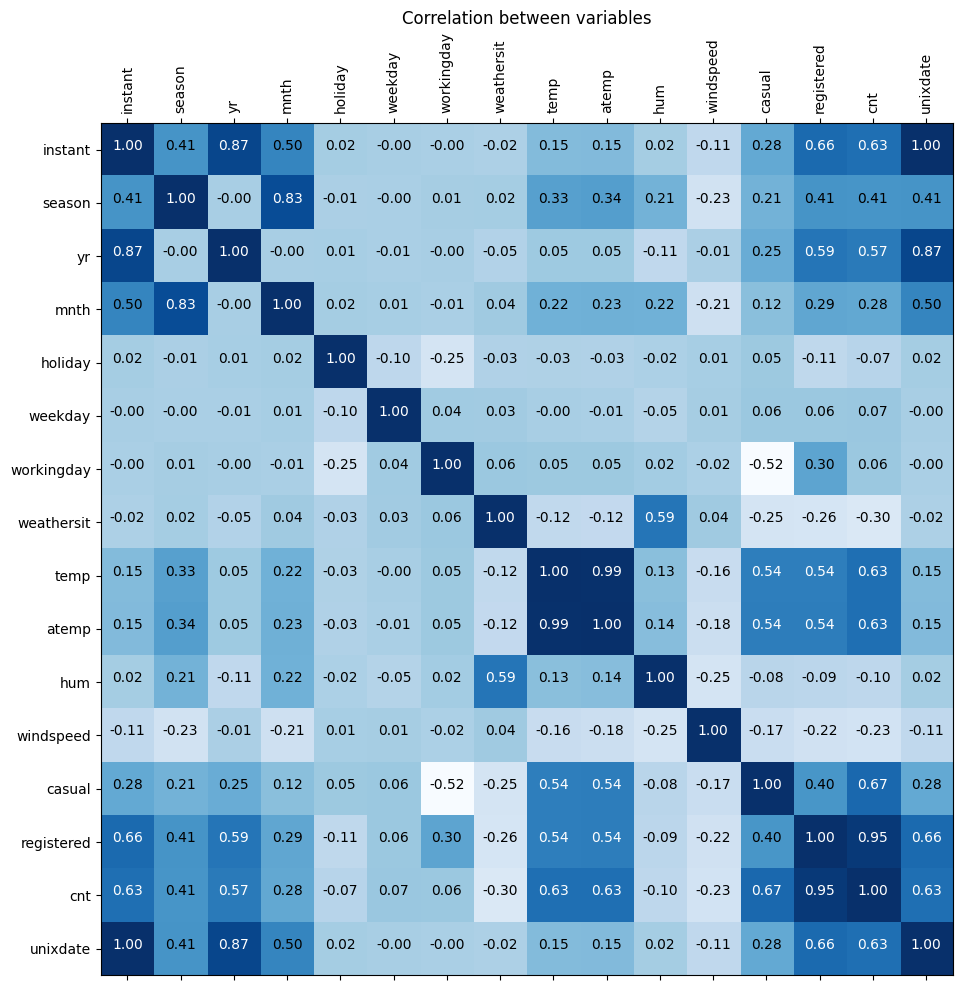

In [11]:
rs = calc_correlation_matrix(df2)
plot_matrix(rs, labels=df2.columns, title="Correlation between variables")

In [12]:
def corr_cols_with_outpout_variable(df, rs, low_correlation_threshold=0.2):
    index_of_cnt = df.columns.index('cnt')
    high_correlation_threshold = 1 - low_correlation_threshold

    columns_to_drop = [
        df.columns[i] for i in range(len(rs))
        if i != index_of_cnt and (np.abs(rs[i][index_of_cnt]) < low_correlation_threshold
        or np.abs(rs[i][index_of_cnt]) > high_correlation_threshold)
    ]

    return columns_to_drop

cols_to_drop = corr_cols_with_outpout_variable(df2, rs)
print(f'Correlated cols with outpout variable: {cols_to_drop}')

Correlated cols with outpout variable: ['holiday', 'weekday', 'workingday', 'hum', 'registered']


In [13]:
df3 = df2.drop(*cols_to_drop)

In [14]:
model = train_and_test(df3)

24/04/29 14:33:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/29 14:33:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Train: r2: 0.818, rmse: 814.148, mse: 662836.421, mae: 610.514
Test: r2: 0.850, rmse: 779.036, mse: 606896.675, mae: 610.876


#### 2.1 Grid search

In [15]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

def get_df_features(df):
    label_col, feature_col = 'cnt', 'features'
    feature_cols = [c for c in df.columns if c not in ['cnt', 'instant']]
    va = VectorAssembler(inputCols=feature_cols, outputCol=feature_col)
    df_features = va.transform(df)
    return df_features
    
def find_best_model_using_param_grid(df_features, lr, paramGrid):
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='cnt', metricName="rmse")

    cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cvModel = cv.fit(df_features)
    return cvModel.bestModel

In [16]:
df3_features = get_df_features(df3)
lr = LinearRegression(featuresCol='features', labelCol='cnt')
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.5, 1, 2, 3, 5, 10]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .build()

In [17]:
bestModel = find_best_model_using_param_grid(df3_features, lr, paramGrid)
print("Best model parameters:")
print("regParam:", bestModel.getRegParam())
print("elasticNetParam:", bestModel.getElasticNetParam())

24/04/29 14:33:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Best model parameters:
regParam: 0.5
elasticNetParam: 1.0


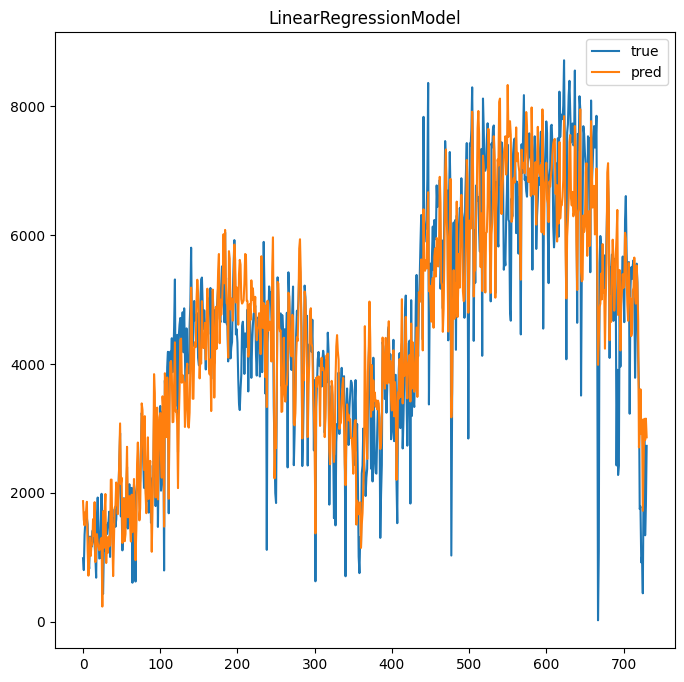

In [74]:
def plot(df, model, start=0, end=-1):
    if end == -1:
        end = df.count()
        
    x = np.arange(start, end)
    y = df.select('cnt').rdd.flatMap(lambda x: x).collect()
    
    df_pred = model.transform(df)
    y_pred = df_pred.select('prediction').rdd.flatMap(lambda x: x).collect()
    
    plt.plot(x, y[start:end], label='true')
    plt.plot(x, y_pred[start:end], label='pred')
    plt.legend()
    plt.title(model.__class__.__name__)
    plt.show()
 
plot(df3_features, bestModel)

#### 2.2 Testowanie innych algorytmów

In [19]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

model_arr = [
    LinearRegression(maxIter=100, regParam=10, elasticNetParam=0.25, labelCol="cnt"),
    DecisionTreeRegressor(labelCol="cnt"),
    RandomForestRegressor(labelCol="cnt"),
    GBTRegressor(labelCol="cnt")
]

for r in model_arr:
    print(f'=== {r.__class__.__name__} ===')
    model = train_and_test(df3, r)

=== LinearRegression ===
Train: r2: 0.818, rmse: 814.326, mse: 663126.404, mae: 610.858
Test: r2: 0.849, rmse: 779.435, mse: 607518.653, mae: 611.533
=== DecisionTreeRegressor ===
Train: r2: 0.882, rmse: 655.535, mse: 429725.575, mae: 473.168
Test: r2: 0.802, rmse: 892.566, mse: 796674.295, mae: 629.250
=== RandomForestRegressor ===
Train: r2: 0.909, rmse: 575.688, mse: 331417.154, mae: 434.627
Test: r2: 0.865, rmse: 739.101, mse: 546270.838, mae: 530.159
=== GBTRegressor ===
Train: r2: 0.970, rmse: 331.951, mse: 110191.662, mae: 254.448
Test: r2: 0.837, rmse: 811.053, mse: 657806.425, mae: 576.666


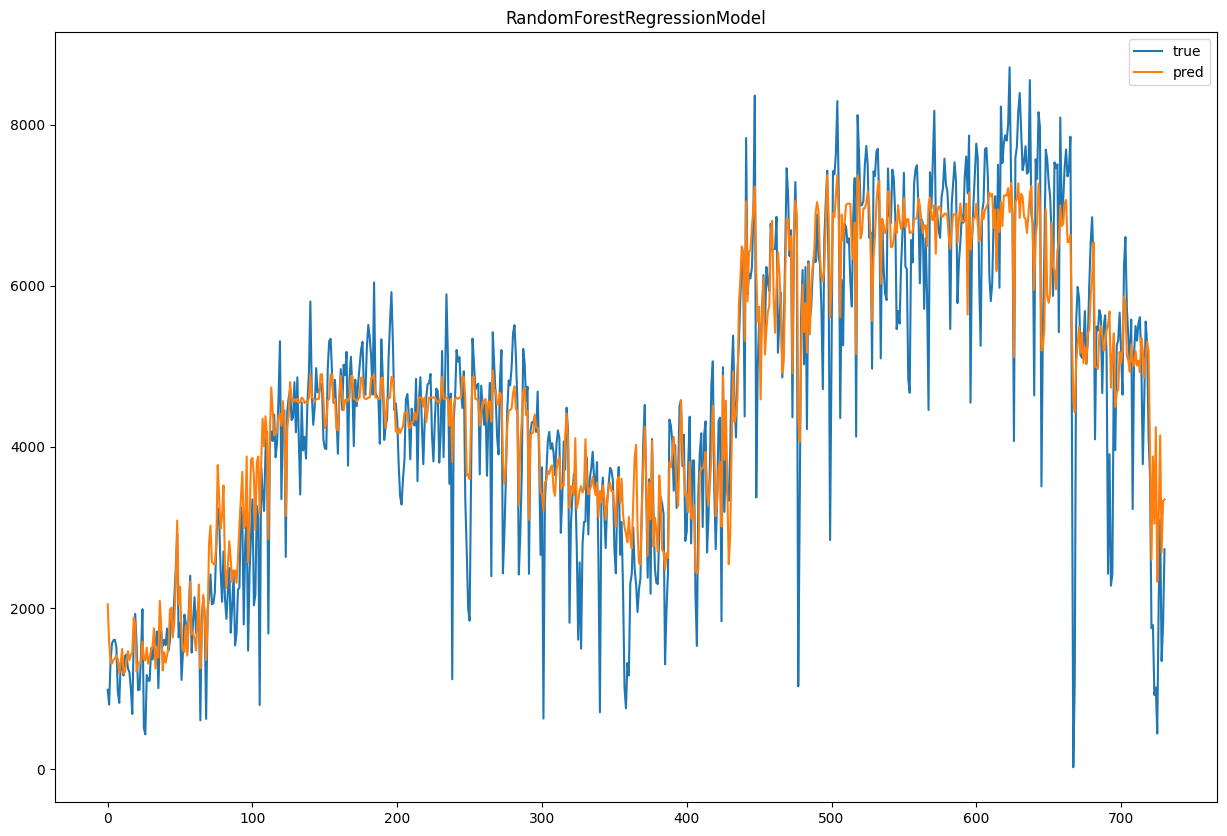

In [20]:
def train_test_split(df):
    df_train, df_test = df.randomSplit([0.7, 0.3], seed=42)
    return df_train, df_test

df_train, df_test = train_test_split(df3_features)

rf = RandomForestRegressor(labelCol='cnt')
rf_model = rf.fit(df_test)

plot(df3_features, rf_model)

### 3. Dane PREPROCESS

#### 3.1 Czy atrybuty są skorelowane ze zmienną cnt?

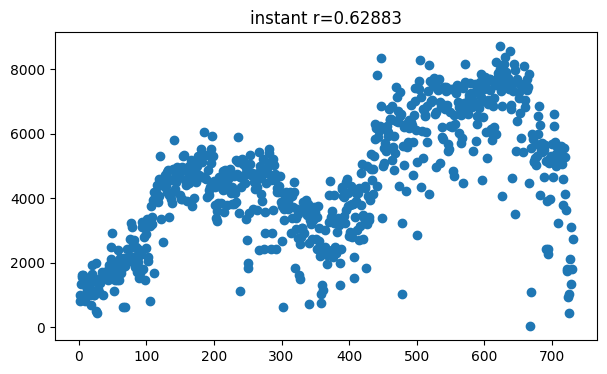

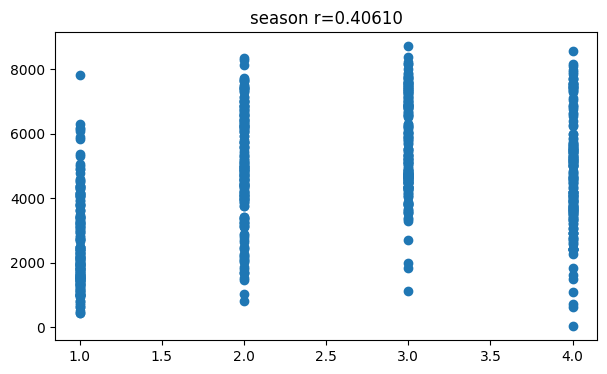

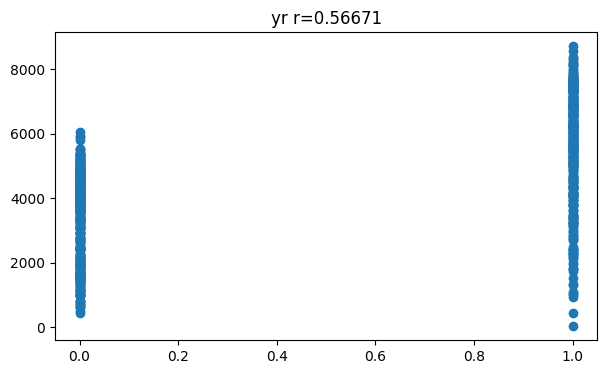

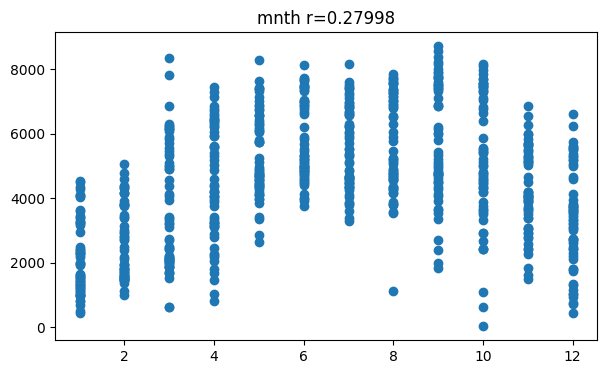

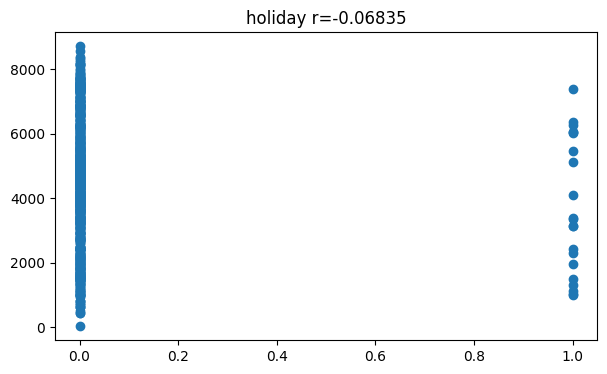

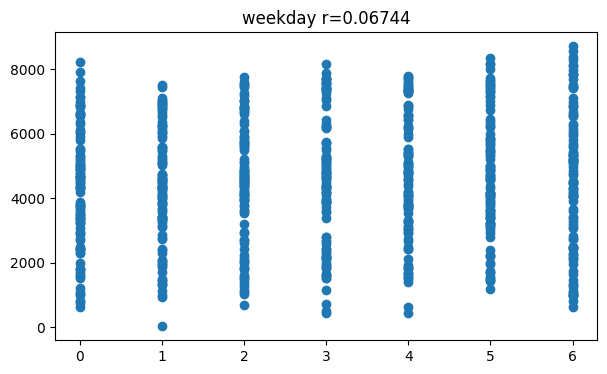

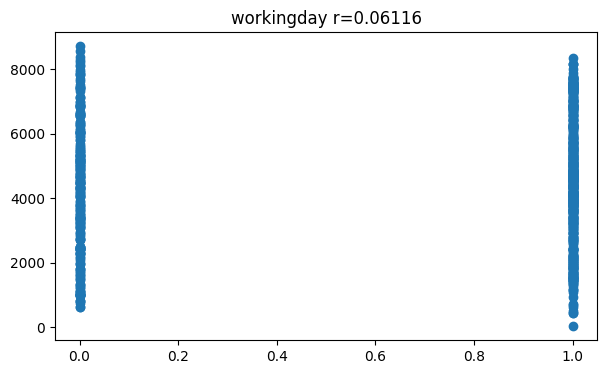

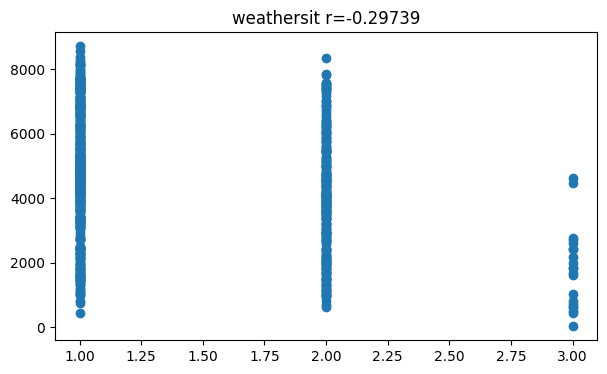

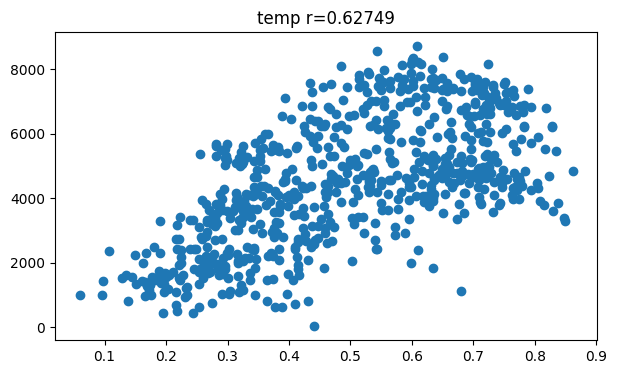

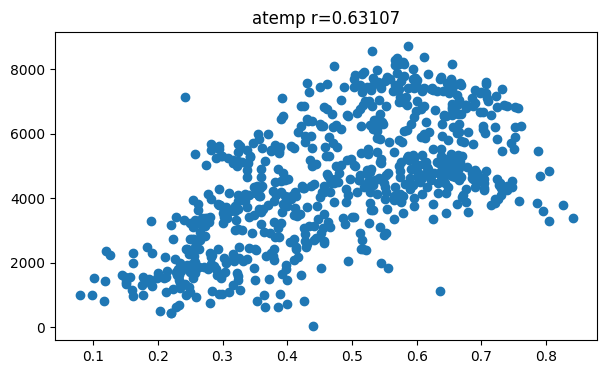

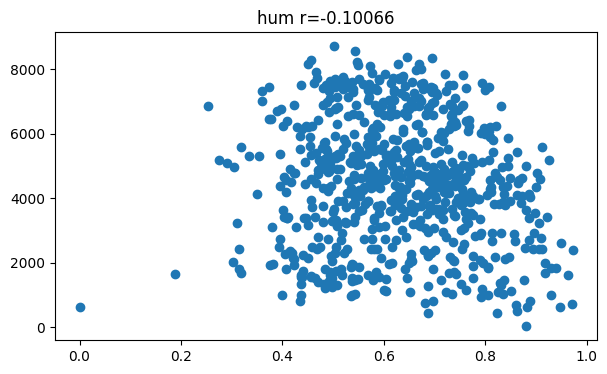

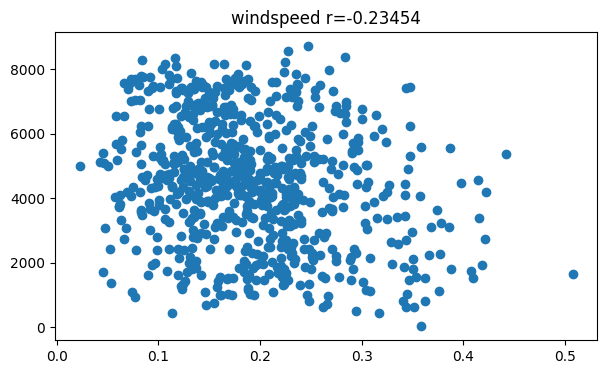

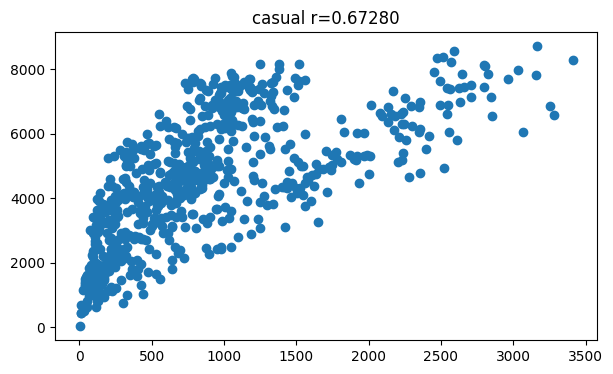

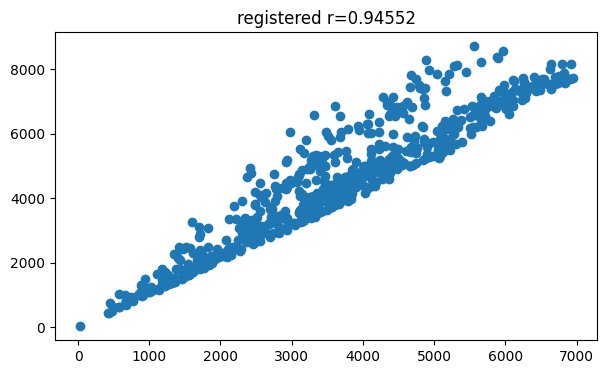

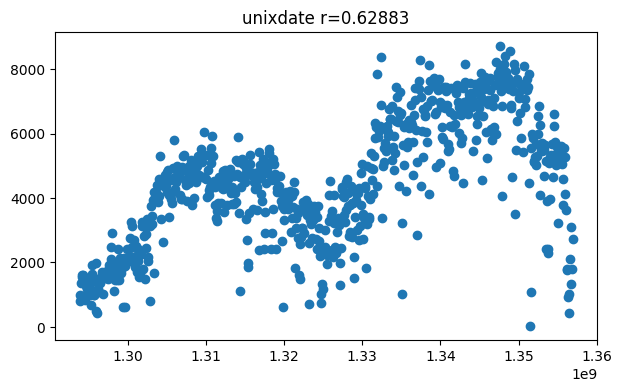

In [21]:
import scipy.stats

def plot_scatter(spark_df, series_names):
    df = spark_df.toPandas()
    plt.rcParams["figure.figsize"] = (7, 4)
    
    for s_name in series_names:
        s = df[s_name]
        r, p = scipy.stats.pearsonr(s, df.cnt)
        plt.figure()
        plt.scatter(s, df.cnt)
        plt.title(f'{s_name} r={r:.5f}')
        plt.show()

series_names = [c for c in df2.columns if c != 'cnt']
plot_scatter(df2, series_names)

# Współczynnik korelacji nie zmieniłby się w zależności od kolejności miesięcy

#### 3.2 Konwersja one-hot i cechy wielomianowe

In [22]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="weekday", outputCol="categoryVec")
model = encoder.fit(df2)
df_encoded = model.transform(df2)
df_encoded.show(5)

+-------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+----------+-------------+
|instant|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered| cnt|  unixdate|  categoryVec|
+-------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+----------+-------------+
|      1|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654| 985|1293840000|    (6,[],[])|
|      2|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670| 801|1293926400|(6,[0],[1.0])|
|      3|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1349|1294012800|(6,[1],[1.0])|
|      4|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|   108

In [23]:
def encode_one_hot(df, col):
    encoder = OneHotEncoder(inputCols=[col], outputCols=[col + "Vec"])
    model = encoder.fit(df)
    df_encoded = model.transform(df)
    
    return df_encoded

In [24]:
df3 = encode_one_hot(df3, 'mnth')
df3 = encode_one_hot(df3, 'season')
df3 = encode_one_hot(df3, 'weathersit')

In [25]:
df3.show(5)

+-------+------+---+----+----------+--------+--------+---------+------+----+----------+--------------+-------------+-------------+
|instant|season| yr|mnth|weathersit|    temp|   atemp|windspeed|casual| cnt|  unixdate|       mnthVec|    seasonVec|weathersitVec|
+-------+------+---+----+----------+--------+--------+---------+------+----+----------+--------------+-------------+-------------+
|      1|     1|  0|   1|         2|0.344167|0.363625| 0.160446|   331| 985|1293840000|(12,[1],[1.0])|(4,[1],[1.0])|(3,[2],[1.0])|
|      2|     1|  0|   1|         2|0.363478|0.353739| 0.248539|   131| 801|1293926400|(12,[1],[1.0])|(4,[1],[1.0])|(3,[2],[1.0])|
|      3|     1|  0|   1|         1|0.196364|0.189405| 0.248309|   120|1349|1294012800|(12,[1],[1.0])|(4,[1],[1.0])|(3,[1],[1.0])|
|      4|     1|  0|   1|         1|     0.2|0.212122| 0.160296|   108|1562|1294099200|(12,[1],[1.0])|(4,[1],[1.0])|(3,[1],[1.0])|
|      5|     1|  0|   1|         1|0.226957| 0.22927|   0.1869|    82|1600|1294185

In [26]:
from pyspark.sql.functions import col, pow

for column in ['temp', 'atemp', 'windspeed']:
    df3 = df3.withColumn(f'{column}_squared', pow(col(column), 2))
    df3 = df3.withColumn(f'{column}_cubed', pow(col(column), 3))

In [27]:
df3.columns

['instant',
 'season',
 'yr',
 'mnth',
 'weathersit',
 'temp',
 'atemp',
 'windspeed',
 'casual',
 'cnt',
 'unixdate',
 'mnthVec',
 'seasonVec',
 'weathersitVec',
 'temp_squared',
 'temp_cubed',
 'atemp_squared',
 'atemp_cubed',
 'windspeed_squared',
 'windspeed_cubed']

In [28]:
model = train_and_test(df3)

Train: r2: 0.866, rmse: 698.014, mse: 487223.604, mae: 517.139
Test: r2: 0.885, rmse: 682.301, mse: 465533.978, mae: 526.698


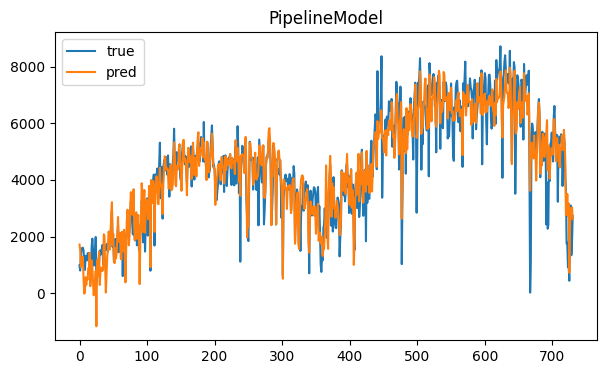

In [29]:
plot(df3, model)

In [30]:
# Model_arr is array of different methods declared in previous lines.

for r in model_arr:
    print(f'=== {r.__class__.__name__} ===')
    model = train_and_test(df3, r)

=== LinearRegression ===
Train: r2: 0.866, rmse: 699.659, mse: 489522.276, mae: 518.672
Test: r2: 0.885, rmse: 681.708, mse: 464726.242, mae: 531.397
=== DecisionTreeRegressor ===
Train: r2: 0.882, rmse: 655.535, mse: 429725.575, mae: 473.168
Test: r2: 0.802, rmse: 892.566, mse: 796674.295, mae: 629.250
=== RandomForestRegressor ===
Train: r2: 0.911, rmse: 569.092, mse: 323865.319, mae: 429.594
Test: r2: 0.872, rmse: 717.744, mse: 515156.559, mae: 528.828
=== GBTRegressor ===
Train: r2: 0.970, rmse: 332.702, mse: 110690.788, mae: 248.974
Test: r2: 0.832, rmse: 823.007, mse: 677341.048, mae: 576.738


### 4. TIMESERIES - regresja szeregów czasowych

In [31]:
from pyspark.ml.feature import PolynomialExpansion

def train_polynomial_features(df, feature_cols, lr=LinearRegression(), degree=2):    
    va = VectorAssembler(inputCols=feature_cols, outputCol='features')
    polyExpansion = PolynomialExpansion(degree=degree, inputCol='features', outputCol='polyFeatures')
    pipeline = Pipeline(stages=[va, polyExpansion, lr])

    model = pipeline.fit(df)
    df_predictions = model.transform(df)

    metrics = evaluate_metrics(df_predictions)
    df_metric_str = ", ".join([f"{metric}: {val:.3f}" for metric, val in metrics.items()])
    print(f"Dataframe metrics: {df_metric_str}")

    return model

In [32]:
feature_cols = ['yr', 'temp', 'atemp', 'hum', 'windspeed']

model = train_polynomial_features(
    df2,
    feature_cols,
    lr = LinearRegression(maxIter=100000, regParam=0.01, elasticNetParam=1, labelCol='cnt'), 
    degree = 3
)

Dataframe metrics: r2: 0.728, rmse: 1009.674, mse: 1019441.896, mae: 791.509


In [33]:
print(model.stages[-1].coefficients)
print('Iterations: ', model.stages[-1].summary.totalIterations)

[2007.206910792541,1709.0857281276194,5233.520505712901,-2257.852065380757,-4082.1881941538245]
Iterations:  54


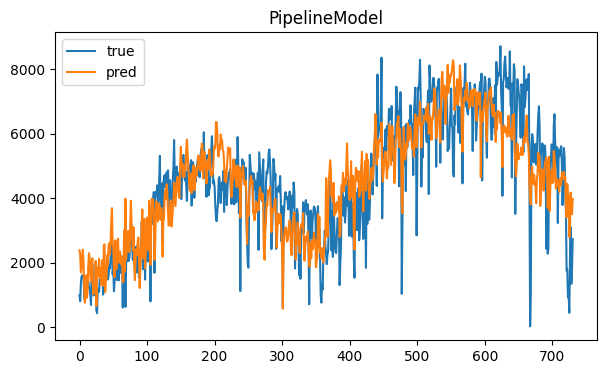

In [34]:
plot(df2, model)

#### 4.2 Analiza cech okresowych

In [135]:
!pip install seaborn
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 8.3 MB/s eta 0:00:00


<Axes: >

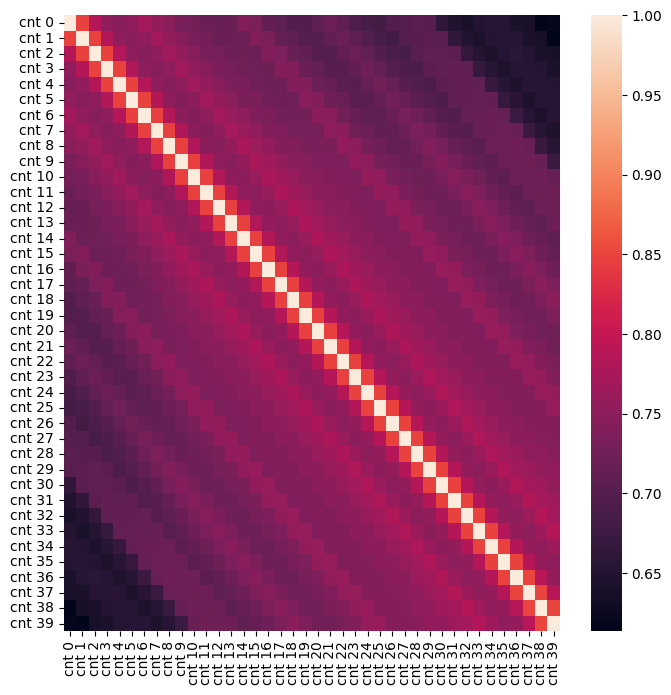

In [36]:
import seaborn as sn
import pandas as pd

pdf = df.toPandas()
shifted = [pd.DataFrame(data = pdf.cnt).shift(i) for i in range(40)]

for i in range(len(shifted)):
  shifted[i].columns=['cnt ' + str(i)]
    
df_shifted = pd.concat(shifted, axis=1)
 
corr_mat = df_shifted.corr()
plt.rcParams['figure.figsize'] = (8, 8)
sn.heatmap(corr_mat, xticklabels = df_shifted.columns, yticklabels = df_shifted.columns)

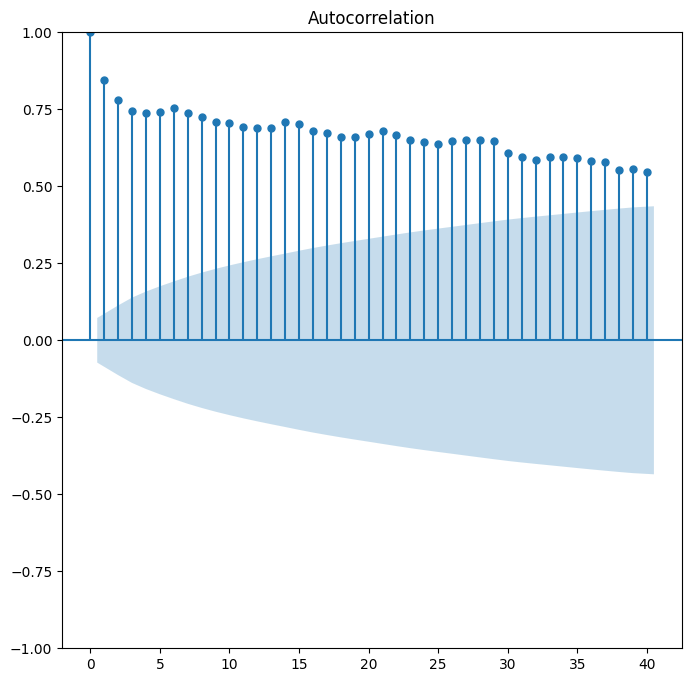

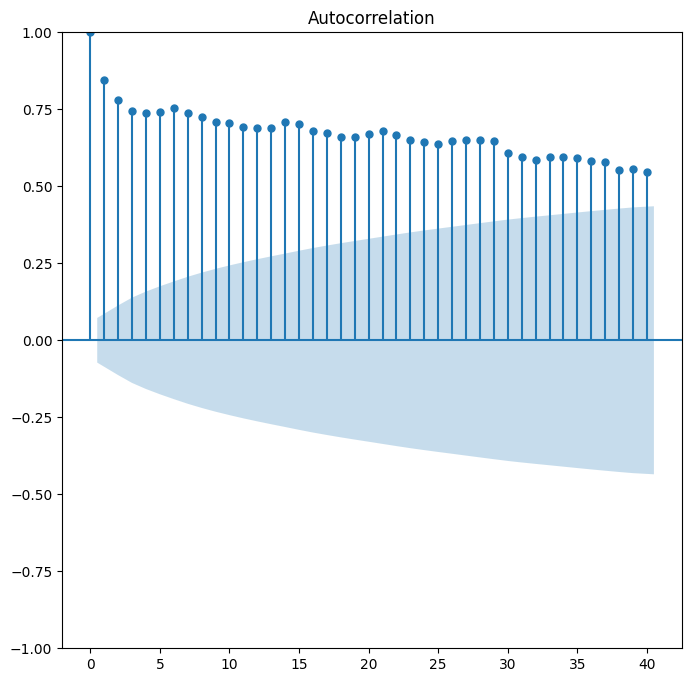

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pdf.cnt, lags=40)

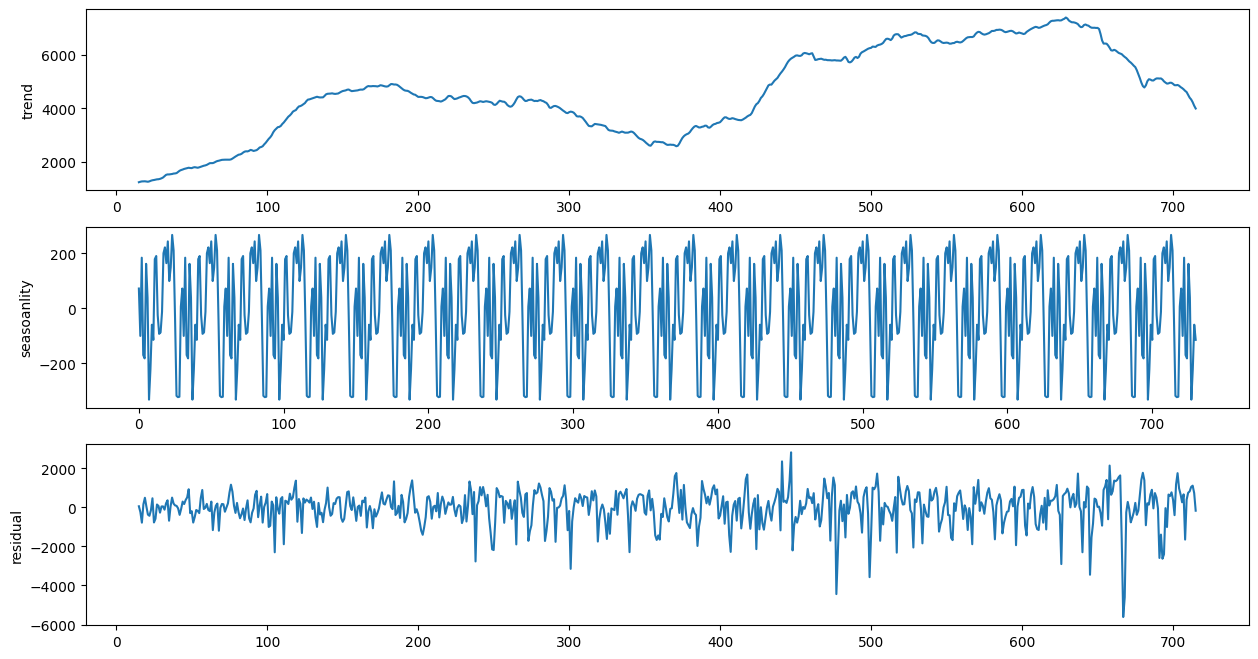

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
 
res = seasonal_decompose(pdf.cnt, model = "additive", period=30)
 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,8))
res.trend.plot(ax = ax1, ylabel = "trend")
res.seasonal.plot(ax = ax2, ylabel = "seasoanlity")
res.resid.plot(ax = ax3, ylabel = "residual")
plt.show()

#### 4.2.2 Analiza częstotliwości

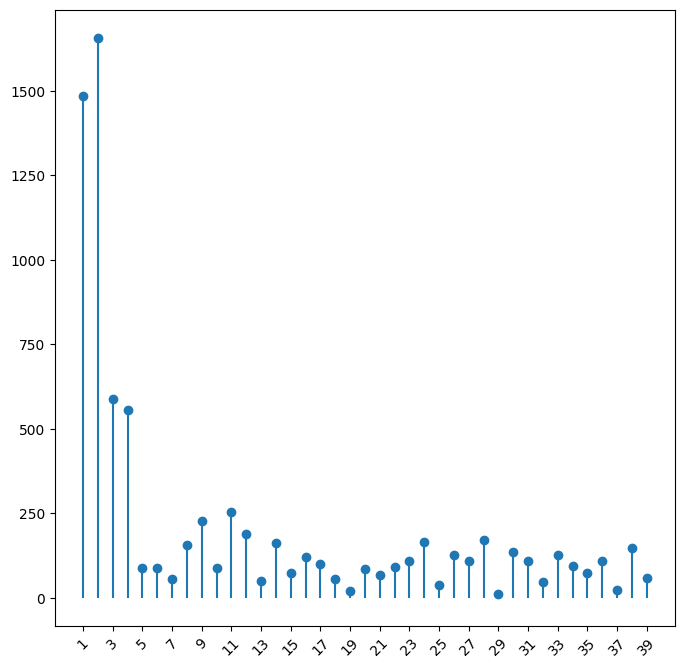

In [39]:
import scipy.fftpack
 
y = pdf.cnt.to_numpy()
x = np.arange(-y.shape[0]//2, y.shape[0]//2)
 
yf = scipy.fftpack.fft(y)
 
N = y.shape[0]
 
yf = scipy.fftpack.fft(y)
yf[0] = 0
xf = np.arange(1, 40)
 
plt.scatter(xf, 2.0/N * np.abs(yf[1:40]))
plt.vlines(xf, np.zeros(39), 2.0/N * np.abs(yf[1:40]))
plt.xticks(xf[::2], rotation = 45)
plt.show()

#### 4.2.3 Cechy okresowe

In [61]:
from pyspark.sql.functions import sin, cos, col, lit, pi

periods = [1, 2, 3, 4, 9, 11, 24, 28, 90]
 
df3 = df
cols = []

for k in periods:
    df3 = df3.withColumn(f'sin_{k}', sin(2 * pi() * col('instant') / k))
    df3 = df3.withColumn(f'cos_{k}', cos(2 * pi() * col('instant') / k))
    cols.append(f'sin_{k}')
    cols.append(f'cos_{k}')

In [72]:
def train_polynomial_periodic_features(df, lr=LinearRegression(), degree=2, cols=[]):
    va = VectorAssembler(inputCols=['instant'], outputCol='features')
    poly_expansion = PolynomialExpansion(degree=degree, inputCol='features', outputCol='features_poly')
    va_merged = VectorAssembler(inputCols=cols + ['features_poly'], outputCol='features_merged')
    pipeline = Pipeline(stages=[va, poly_expansion, va_merged, lr])

    model = pipeline.fit(df)
    predictions = model.transform(df)

    metrics = evaluate_metrics(predictions)
    df_metric_str = ", ".join([f"{metric}: {val:.3f}" for metric, val in metrics.items()])
    print(f"Dataframe metrics: {df_metric_str}")

    return model

Dataframe metrics: r2: 0.395, rmse: 1505.234, mse: 2265729.019, mae: 1229.914
[5.7664488996449625]
Iterations:  3


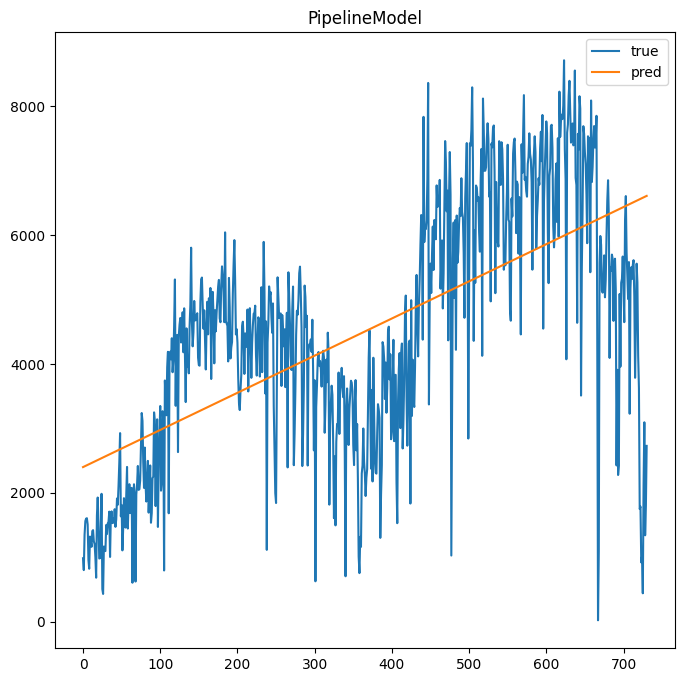

In [75]:
# Probably something is wrong here :/
model = train_polynomial_periodic_features(
    df3,
    lr = LinearRegression(maxIter=1000, regParam=0.5, elasticNetParam=1, labelCol='cnt'),
    degree = 3,
    cols = cols
)

print(model.stages[-1].coefficients)
print('Iterations: ', model.stages[-1].summary.totalIterations)
plot(df3, model)